# Term Project for Course SCS_3546-022 Deep learning 
### Team members
<pre> X503490 Yipeng Cai</pre>
<pre> X501279 Yunchen Li</pre>
<pre> X501273 Yue Shu</pre>

##### Kaggle competition https://www.kaggle.com/competitions/feedback-prize-english-language-learning
###### The goal of this competition is to assess the language proficiency of 8th-12th grade English Language Learners (ELLs). Utilizing a dataset of essays written by ELLs will help to develop proficiency models that better supports all students.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')       


absolute_path = '/content/gdrive/MyDrive/EEL_dataset/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import re
import string
import sklearn
from sklearn.model_selection import train_test_split

import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from collections import Counter
from IPython.core.display import display, HTML

from sklearn.feature_extraction.text import CountVectorizer
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
sample_sub = pd.read_csv(absolute_path + 'sample_submission.csv')
test_ds = pd.read_csv(absolute_path + 'test.csv')
train_ds = pd.read_csv(absolute_path + 'train.csv.zip')

In [ ]:
train_ds

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


In [ ]:
EEL_metrics = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar',
       'conventions']

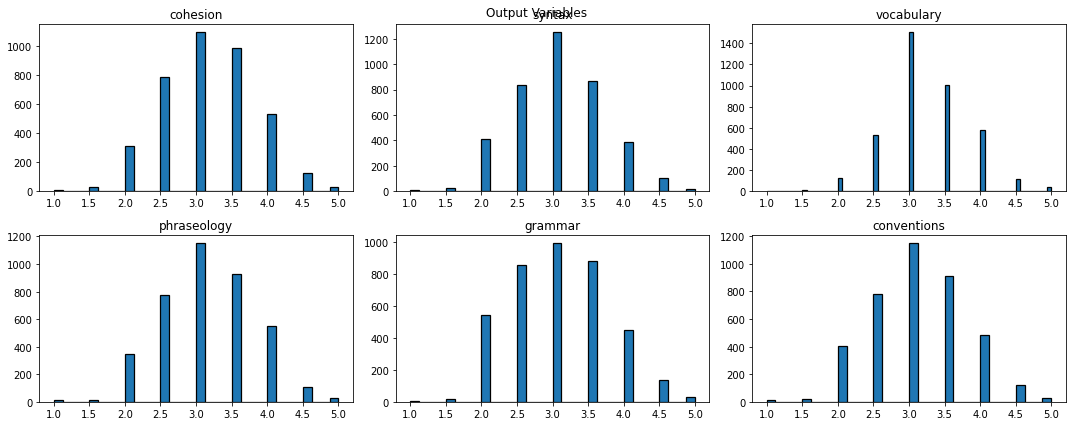

In [ ]:
fig, axes = plt.subplots(2, len(EEL_metrics)//2, figsize=(15,6))

for i, EEL_metric in enumerate(EEL_metrics):
    ax = axes.flat[i]
    sns.histplot(x=EEL_metric, data=train_ds, linewidth=1.25, alpha=1, ax=ax, zorder=2)
    ax.set_title(EEL_metric)
    ax.set(xlabel=None, ylabel=None)
    
fig.suptitle('Output Variables')
plt.tight_layout()
plt.show()

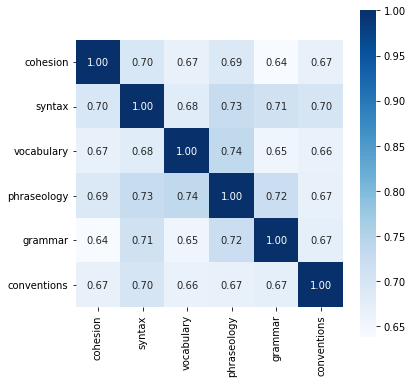

In [ ]:
corr = train_ds[EEL_metrics].corr()
fig, ax = plt.subplots(figsize=(6,6))        
sns.heatmap(corr, 
            xticklabels=corr.columns, yticklabels=corr.columns, 
            square=True, annot=True, cmap="Blues", fmt=".2f")
plt.show()

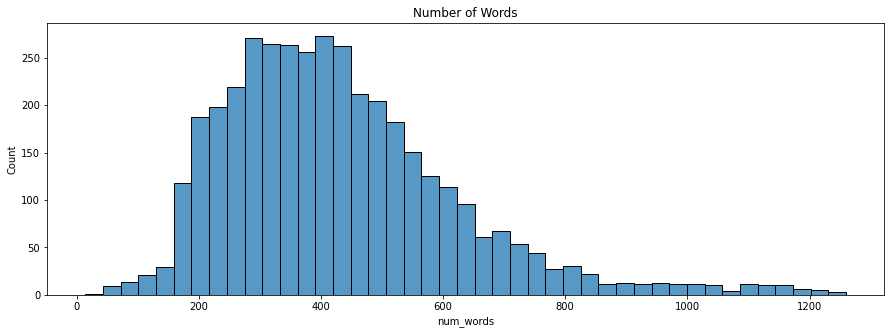

In [ ]:
fig = plt.figure(figsize=(15, 5))
train_ds['num_words'] = train_ds['full_text'].apply(lambda x: len(x.split()))
sns.histplot(data=train_ds, x="num_words")
plt.title("Number of Words")
plt.show()

In [ ]:
fig = px.histogram(train_ds, x = train_ds['full_text'].str.len(), marginal="box", 
                   title = "Number of Words", color_discrete_sequence=["#FFA200"])
fig.update_layout(bargap=0.2)
fig.update_layout(template="plotly_dark", font=dict(family="PT Sans", size=18, color="#C4FEFF"))
fig.show()

In [ ]:
max_num_words = int(train_ds['num_words'].describe()[-1])
max_num_words

1260

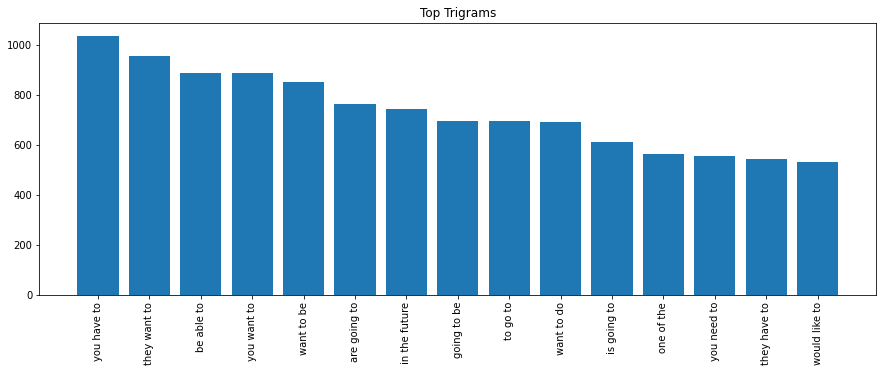

In [ ]:
fig = plt.figure(figsize=(15, 5))

def get_top_bigrams(corpus, n):
    vectorizer = CountVectorizer(ngram_range=(n,n)).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq

top_bigrams = get_top_bigrams(train_ds['full_text'], n=3)[:15]
x, y = map(list, zip(*top_bigrams))
plt.bar(x, y)
plt.title('Top Trigrams')
plt.xticks(rotation=90)
plt.show()

Preprocessing

In [ ]:
## Since we are trying analysis all six english metrics, its better not to preprocess too much
## Like grammaer, spelling etc, all kinds of thing are affecting the final grade.
## Following is just simply lower the case and replace the \n with space and delete some spaces in the text( was seen in the example)

import re
import string
def preprocessing(doc):
    doc = doc.lower()
    #doc = re.sub('\[.*?\]', ' ', doc)
    #doc = re.sub('[%s]' % re.escape(string.punctuation), ' ', doc)
    #doc = re.sub('\w*\d\w*',' ', doc)
    doc = re.sub('\n',' ', doc)
    #doc = re.sub('[''""...]',' ', doc)
    doc = ' '.join(doc.split())
    return doc

In [ ]:
test_text = 'Am    so    bad at   DL'
' '.join(test_text.split())

'Am so bad at DL'

In [ ]:
train_ds['cleaned_full_text'] = train_ds['full_text'].apply(lambda x: preprocessing(x))
test_ds['cleaned_full_text'] = test_ds['full_text'].apply(lambda x: preprocessing(x))

In [ ]:
train_ds['cleaned_full_text'][0]

"i think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home. the hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear. most students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go take a 

In [ ]:
train_ds['full_text'][0]

"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go t

In [ ]:
## there are in total 9 grades from 1 to 5 with 0.5 steps
## replace it with labels from 0 to 8, if we try with classification models.
Scores = train_ds[EEL_metrics].replace(
    [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0, 1, 2, 3, 4, 5, 6, 7, 8])

Scores = Scores.astype('int')
Scores

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,5,5,4,4,6,4
1,3,3,4,2,2,3
2,4,5,4,4,4,3
3,7,7,7,7,6,8
4,3,4,4,4,3,3
...,...,...,...,...,...,...
3906,3,4,4,5,3,3
3907,6,6,6,6,5,4
3908,3,4,4,4,5,4
3909,6,7,7,6,7,7


In [ ]:
num_class = len(set(Scores['cohesion']))
num_class

9

In [ ]:
### As we see that the training data is skewed and imbalanced for each class,
### below refer to functions of the class weights from assign 2 solutions

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer

# reference: https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [ ]:
class_weights_x_train = generate_class_weights(Scores['cohesion'])
class_weights_x_train

### Seeing below, weight is much higher for class(0,1,8)--score(1,1,5,5), 
### Cause of much less training data for class (0,1,8)

{0: 43.455555555555556,
 1: 16.094650205761315,
 2: 1.3795414462081128,
 3: 0.550070323488045,
 4: 0.39649229521492296,
 5: 0.4398335582546109,
 6: 0.8137744486059093,
 7: 3.4764444444444442,
 8: 16.713675213675213}

In [ ]:
from collections import Counter
Counter(Scores['cohesion'])
## a simply look that class0 has 10 samples while class5 has 988 samples.

Counter({5: 988, 3: 790, 4: 1096, 7: 125, 6: 534, 2: 315, 0: 10, 8: 26, 1: 27})

### 1)First Try with Bert Classifier

In [ ]:
### Split the dataset
X_train, X_val, Y_train,  Y_val = train_test_split(train_ds['cleaned_full_text'], Scores['cohesion'])

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 30.3 MB/s 
     |████████████████████████████████| 7.6 MB 50.8 MB/s 
     |████████████████████████████████| 182 kB 67.5 MB/s 


In [ ]:
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification

In [ ]:
## Use the own  style of tokenizer from Bert 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
## max length for Bert was 512, things longer are chopped
max_words = 512

In [ ]:
## def the functions to generate the inputs for Bert
## it returns the input_ids and attention_masks
def mask_inputs_bert(texts):
  input_ids = []
  attention_masks = []
  for text in texts:
    encoder_dict = tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = max_words,
        padding='max_length',
        return_attention_mask = True,
        truncation=True,
    )
    input_ids.append(encoder_dict['input_ids'])
    attention_masks.append(encoder_dict['attention_mask'])
  input_ids = tf.convert_to_tensor(input_ids)
  attention_masks = tf.convert_to_tensor(attention_masks)
  return input_ids, attention_masks

In [ ]:
## Function act on the training dataset.
x_train, x_train_mask = mask_inputs_bert(X_train)
x_val,x_val_mask = mask_inputs_bert(X_val)

y_train = tf.convert_to_tensor(Y_train)
y_val = tf.convert_to_tensor(Y_val)

In [ ]:
### Double check the shape of the data before feed into the model

x_train.shape, y_train.shape, x_train_mask.shape, y_val.shape

(TensorShape([2933, 512]),
 TensorShape([2933]),
 TensorShape([2933, 512]),
 TensorShape([978]))

In [ ]:
### since we have 9 classes, here trying use num_labels = 9
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels = 9)

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# set up the Classification model 
#loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#metric = tf.keras.metrics.CategoricalAccuracy('accuracy')
#optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, epsilon = 1e-08)
rmse = tf.keras.metrics.RootMeanSquaredError(name='rmse')

bert_model.compile(loss = 'mse', optimizer = 'adam' ,metrics = [rmse])

bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_54 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  6921      
                                                                 
Total params: 109,489,161
Trainable params: 109,489,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### As found in the documents, its recommended to train with 2 or 4 epochs,
### Here we also pass in the class_weight,

hisotry = bert_model.fit([x_train,x_train_mask], y_train,
                         epochs = 4,
                         batch_size = 1,
                         validation_data = ([x_val,x_val_mask], y_val),
                         class_weight = class_weights_x_train
                         )

Epoch 1/4
2933/2933 [==============================] - 498s 163ms/step - loss: 11.6062 - rmse: 2.4696 - val_loss: 2.7133 - val_rmse: 1.6472
Epoch 2/4
2933/2933 [==============================] - 477s 163ms/step - loss: 10.6325 - rmse: 2.4939 - val_loss: 1.7905 - val_rmse: 1.3381
Epoch 3/4
2933/2933 [==============================] - 477s 163ms/step - loss: 11.3189 - rmse: 2.4336 - val_loss: 5.1288 - val_rmse: 2.2647
Epoch 4/4
2933/2933 [==============================] - 473s 161ms/step - loss: 10.5393 - rmse: 2.4511 - val_loss: 2.3860 - val_rmse: 1.5447


In [ ]:
#Same steps for prepare the test dataset
test_ds['cleaned_full_text'] = test_ds['full_text'].apply(lambda x: preprocessing(x))
x_test, x_test_mask = mask_inputs_bert(test_ds)

In [ ]:
logits = bert_model.predict([x_test, x_test_mask])

1/1 [==============================] - 3s 3s/step


In [ ]:
probabilities = tf.nn.sigmoid(logits.logits)
probabilities
### This is just for one class the cohesion Bert classifying. stop here try with other model
### which generates all the results at one. ie. the nns

<tf.Tensor: shape=(3, 9), dtype=float32, numpy=
array([[0.99342453, 0.993515  , 0.9936977 , 0.9935242 , 0.99353033,
        0.9935278 , 0.9935454 , 0.9934068 , 0.99393505],
       [0.99342453, 0.993515  , 0.9936977 , 0.9935242 , 0.99353033,
        0.9935278 , 0.9935454 , 0.9934068 , 0.99393505],
       [0.99342453, 0.993515  , 0.9936977 , 0.9935242 , 0.99353033,
        0.9935278 , 0.9935454 , 0.9934068 , 0.99393505]], dtype=float32)>

In [ ]:
score_list = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

### scores shall falls into certain classes, there is no  2.25-like grade,
### has to be 2 or 2.5 Here is a simple function.

def Avg_scores(list):
  sum = 0
  for i, j in zip(list, score_list):
    sum += i*j
  if not sum >= 1.25:
    return 1
  if not sum >= 2:
    return 1.5
  if not sum >= 2.25:
    return 2
  if not sum >= 3:
    return 2.5
  if not sum >= 3.25:
    return 3
  if not sum >= 4:
    return 3.5
  if not sum >= 4.25:
    return 4
  if not sum >= 5:
    return 4.5
  
  return 5

### 2) try with a td-idf and neuron network

In [ ]:
##Using the TF-IDF algorithm to find the value in each token slot.
vectorizor = keras.layers.TextVectorization(
    max_tokens=max_num_words, 
    output_mode="tf-idf", 
    ngrams=3
)
vectorizor.adapt(list(train_ds["cleaned_full_text"]))

In [ ]:
# construct a baseline learning model
Dropout_rate = 0.2
def base_model_1():
    model = keras.Sequential([
        keras.Input(shape=(), dtype="string"),
        vectorizor,
        keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal"),
        keras.layers.Dropout(Dropout_rate),
        keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal"),
        keras.layers.Dropout(Dropout_rate),
        keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal"),
        keras.layers.Dropout(Dropout_rate),
        keras.layers.Dense(64, activation='relu', kernel_initializer="he_normal"),
        keras.layers.Dropout(Dropout_rate),
        keras.layers.Dense(6)
    ])
    
    #model.compile(
        #loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
       # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
       # metrics=["accuracy"])
    #callback = keras.callbacks.EarlyStopping(monitor="val_rmse", mode="min", patience=6)
    rmse = tf.keras.metrics.RootMeanSquaredError(name='rmse')
    model.compile(metrics = [rmse], optimizer='adam',loss = 'mse')
    return model

### Glad to use the defined plotting function

#  """Plots train and val learning curves for mse (loss)
# and rmse (our metric), given a model training history. 
#  """
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('[MSE]')
    plt.legend()
    plt.grid(True)
    
def plot_mse(history):
    plt.plot(history.history['rmse'], label='rmse')
    plt.plot(history.history['val_rmse'], label='val_rmse')
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error')
    plt.legend()
    plt.grid(True)    
  

In [ ]:
model1 = base_model_1()
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 1260)             1         
 ectorization)                                                   
                                                                 
 dense_25 (Dense)            (None, 512)               645632    
                                                                 
 dropout_55 (Dropout)        (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 dropout_56 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 128)               32896     
                                                      

In [ ]:
from keras.utils import plot_model



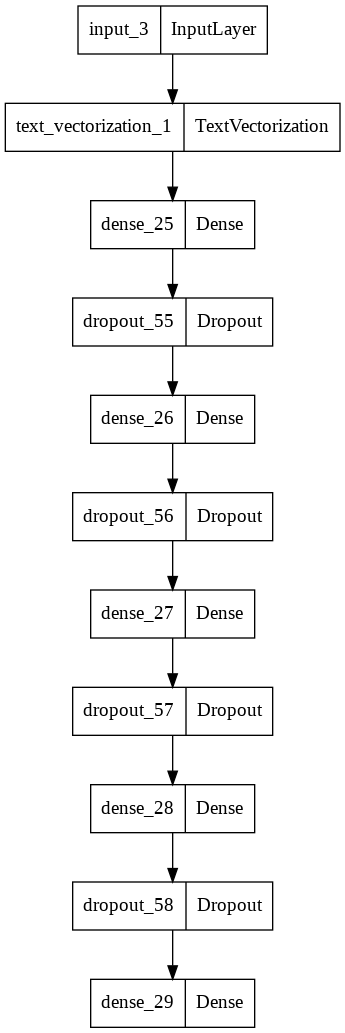

In [ ]:
plot_model(model1, to_file='Base_model.png')

In [ ]:
x_1 = train_ds['cleaned_full_text']
y_1 = train_ds[EEL_metrics]


In [ ]:
history_1 = model1.fit(x_1,y_1, epochs=50, validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/50
98/98 [==============================] - 2s 14ms/step - loss: 658.3455 - rmse: 25.6582 - val_loss: 9.6551 - val_rmse: 3.1073
Epoch 2/50
98/98 [==============================] - 1s 12ms/step - loss: 29.3463 - rmse: 5.4172 - val_loss: 8.8299 - val_rmse: 2.9715
Epoch 3/50
98/98 [==============================] - 1s 12ms/step - loss: 14.7192 - rmse: 3.8366 - val_loss: 6.1765 - val_rmse: 2.4853
Epoch 4/50
98/98 [==============================] - 1s 12ms/step - loss: 9.8127 - rmse: 3.1325 - val_loss: 3.8067 - val_rmse: 1.9511
Epoch 5/50
98/98 [==============================] - 1s 12ms/step - loss: 6.9050 - rmse: 2.6277 - val_loss: 2.6332 - val_rmse: 1.6227
Epoch 6/50
98/98 [==============================] - 1s 12ms/step - loss: 5.2776 - rmse: 2.2973 - val_loss: 2.4788 - val_rmse: 1.5744
Epoch 7/50
98/98 [==============================] - 1s 12ms/step - loss: 4.5583 - rmse: 2.1350 - val_loss: 2.1898 - val_rmse: 1.4798
Epoch 8/50
98/98 [==============================] - 1s 12ms/step

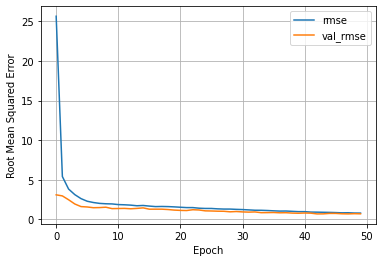

In [ ]:
plot_mse(history_1)

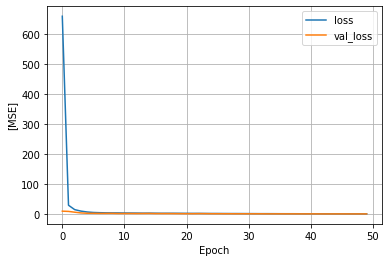

In [ ]:
plot_loss(history_1)

In [ ]:
prediction_1 = model1.predict(test_ds['cleaned_full_text'])
prediction_1

1/1 [==============================] - 0s 131ms/step


array([[2.8058252, 2.900129 , 2.8493443, 2.7694142, 2.6940746, 2.8481843],
       [2.5737307, 2.7686267, 2.580152 , 2.5030494, 2.4388149, 2.649234 ],
       [2.8019574, 2.8979375, 2.8448582, 2.764975 , 2.6898208, 2.844869 ]],
      dtype=float32)

In [ ]:
for i in range(len(EEL_metrics)):
    column = EEL_metrics[i]
    sample_sub[column] = prediction_1[:, i]   

sample_sub

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,2.805825,2.900129,2.849344,2.769414,2.694075,2.848184
1,000BAD50D026,2.573731,2.768627,2.580152,2.503049,2.438815,2.649234
2,00367BB2546B,2.801957,2.897938,2.844858,2.764975,2.689821,2.844869


### 3) Try with LSTMlayer with a more complex network

In [ ]:
max_num_words

1260

In [ ]:
### Use tokenizer and use OOV for out of valcublary, ##

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_ds['cleaned_full_text'])
word_index = tokenizer.word_index

word_idx_count = len(word_index)

### padding to max_num_words which is 1260, will truncating if passed.
train_seq = tokenizer.texts_to_sequences(train_ds['cleaned_full_text'])
pad_train = pad_sequences(train_seq,maxlen=max_num_words, truncating='post')

test_seq = tokenizer.texts_to_sequences(test_ds['cleaned_full_text'])
pad_test = pad_sequences(test_seq,maxlen=max_num_words, truncating='post')

In [ ]:
print(word_idx_count)

22157


In [ ]:
pad_train[0].shape

(1260,)

In [ ]:
#X = pad_train
#y_train= []
#for i in range(len(EEL_metrics)):
#    y_train.append(train_ds[EEL_metrics[i]].to_numpy())

#y = train_ds[EEL_metrics].to_numpy()
#y

In [ ]:
### Pass dataset to X and y for later training
X = pad_train
X_test = pad_test
y = [train_ds['cohesion'].values, train_ds['syntax'].values, train_ds['vocabulary'].values,
      train_ds['phraseology'].values, train_ds['grammar'].values, train_ds['conventions'].values]
y

[array([3.5, 2.5, 3. , ..., 2.5, 4. , 3.5]),
 array([3.5, 2.5, 3.5, ..., 3. , 4.5, 2.5]),
 array([3. , 3. , 3. , ..., 3. , 4.5, 3.5]),
 array([3., 2., 3., ..., 3., 4., 3.]),
 array([4. , 2. , 3. , ..., 3.5, 4.5, 3. ]),
 array([3. , 2.5, 2.5, ..., 3. , 4.5, 3.5])]

In [ ]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
Dropout_rate = 0.5

def custom_LSTM_model():
    # input layer
    inputs = Input(shape=(max_num_words))
    embeddings =Embedding(word_idx_count + 1, 512, input_length=max_num_words)(inputs)
    LSTM_layer1 = Bidirectional(LSTM(512, return_sequences=True))(embeddings)
    LSTM_layer2 = Bidirectional(LSTM(64))(LSTM_layer1)
    Dense1 = Dense(512, activation='relu', kernel_initializer="he_normal")(LSTM_layer2)
    dropout1 = Dropout(Dropout_rate)(Dense1)
    Dense2 = Dense(256, activation='relu', kernel_initializer="he_normal")(dropout1)

    Dense11 = Dense(128, activation='relu', kernel_initializer="he_normal")(Dense2)
    dropout12 = Dropout(Dropout_rate)(Dense11)
    Dense13 = Dense(64, activation='relu', kernel_initializer="he_normal")(dropout12)
    dropout14 = Dropout(Dropout_rate)(Dense13)
    Output1 = Dense(1, activation='relu')(dropout14)

    Dense21 = Dense(128, activation='relu', kernel_initializer="he_normal")(Dense2)
    dropout22 = Dropout(Dropout_rate)(Dense21)
    Dense23 = Dense(64, activation='relu', kernel_initializer="he_normal")(dropout22)
    dropout24 = Dropout(Dropout_rate)(Dense23)
    Output2 = Dense(1, activation='relu')(dropout24)


    Dense31 = Dense(128, activation='relu', kernel_initializer="he_normal")(Dense2)
    dropout32 = Dropout(Dropout_rate)(Dense31)
    Dense33 = Dense(64, activation='relu', kernel_initializer="he_normal")(dropout32)
    dropout34 = Dropout(Dropout_rate)(Dense33)
    Output3 = Dense(1, activation='relu')(dropout34)


    Dense41 = Dense(128, activation='relu', kernel_initializer="he_normal")(Dense2)
    dropout42 = Dropout(Dropout_rate)(Dense41)
    Dense43 = Dense(64, activation='relu', kernel_initializer="he_normal")(dropout42)
    dropout44 = Dropout(Dropout_rate)(Dense43)
    Output4 = Dense(1, activation='relu')(dropout44)

    Dense51 = Dense(128, activation='relu', kernel_initializer="he_normal")(Dense2)
    dropout52 = Dropout(Dropout_rate)(Dense51)
    Dense53 = Dense(64, activation='relu', kernel_initializer="he_normal")(dropout52)
    dropout54 = Dropout(Dropout_rate)(Dense53)
    Output5 = Dense(1, activation='relu')(dropout54)

    Dense61 = Dense(128, activation='relu', kernel_initializer="he_normal")(Dense2)
    dropout62 = Dropout(Dropout_rate)(Dense61)
    Dense63 = Dense(64, activation='relu', kernel_initializer="he_normal")(dropout62)
    dropout64 = Dropout(Dropout_rate)(Dense63)
    Output6 = Dense(1, activation='relu')(dropout64)


    model = Model(inputs=inputs, outputs=[Output1, Output2, Output3, Output4, Output5, Output6])
    
    return model
# summarize layers


In [ ]:
model_custom  = custom_LSTM_model()

print(model_custom.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1260)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1260, 512)    11344896    ['input_5[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 1260, 1024)  4198400     ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 128)         557568      ['bidirectional_2[0][0]']  

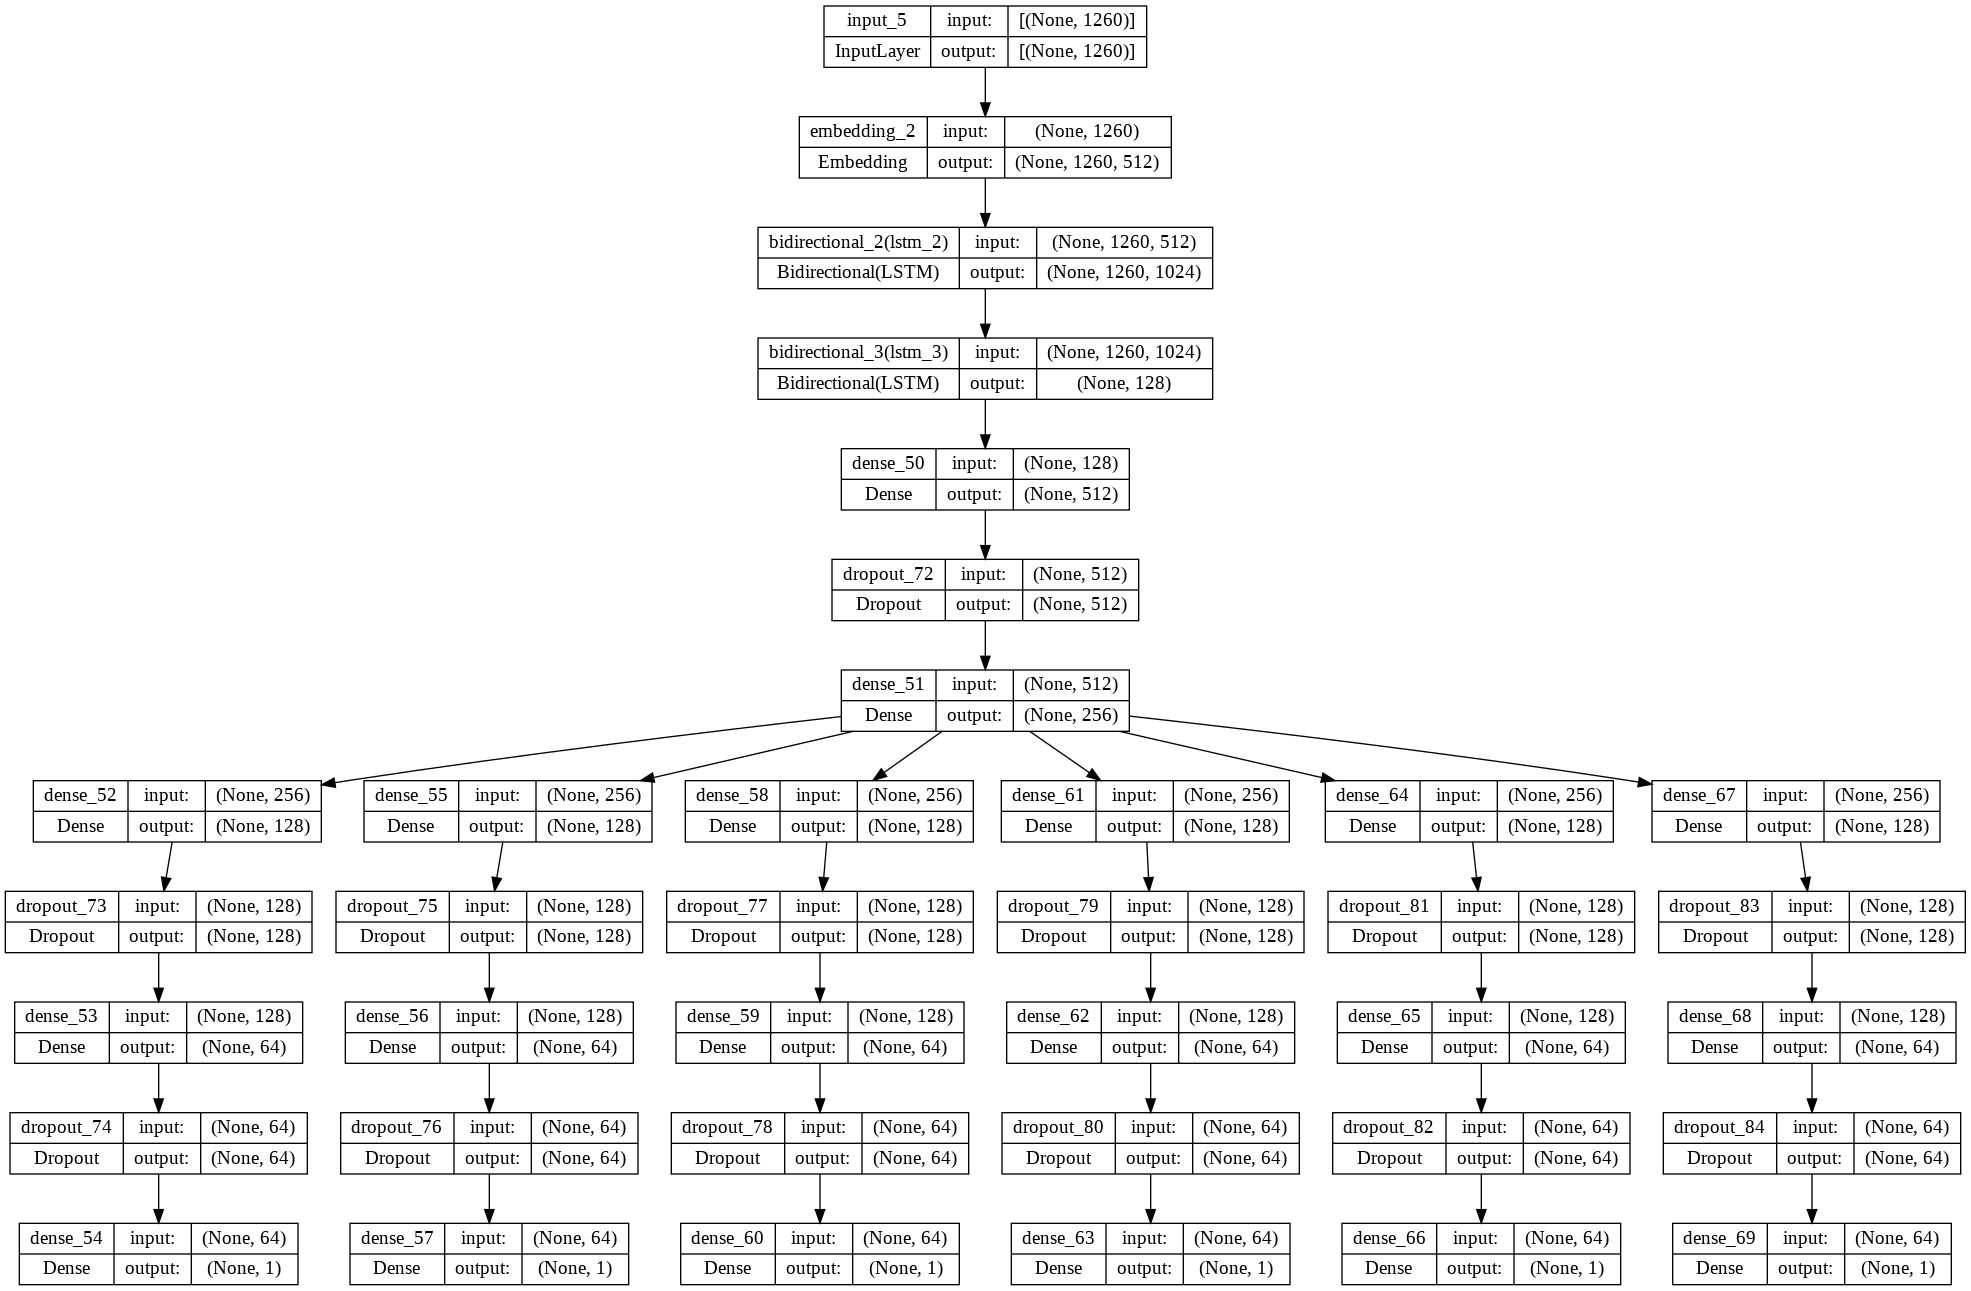

In [ ]:
# plot graph
plot_model(model_custom, show_shapes=True, to_file='multiple_outputs.png')

In [ ]:
rmse = tf.keras.metrics.RootMeanSquaredError(name="rmse")
early_stop = keras.callbacks.EarlyStopping(monitor="val_rmse", mode="min", patience=5)
model_custom.compile(loss="mse", optimizer="adam", metrics=[rmse])

In [ ]:
history_2 = model_custom.fit(X, y, epochs=50, validation_split=0.2, shuffle=True)

Epoch 1/50
98/98 [==============================] - 70s 638ms/step - loss: 11.7994 - dense_54_loss: 2.1211 - dense_57_loss: 1.8287 - dense_60_loss: 2.1375 - dense_63_loss: 2.0645 - dense_66_loss: 1.7756 - dense_69_loss: 1.8720 - dense_54_rmse: 1.4564 - dense_57_rmse: 1.3523 - dense_60_rmse: 1.4620 - dense_63_rmse: 1.4368 - dense_66_rmse: 1.3325 - dense_69_rmse: 1.3682 - val_loss: 4.1140 - val_dense_54_loss: 0.6932 - val_dense_57_loss: 0.6537 - val_dense_60_loss: 0.5046 - val_dense_63_loss: 0.6546 - val_dense_66_loss: 0.8412 - val_dense_69_loss: 0.7667 - val_dense_54_rmse: 0.8326 - val_dense_57_rmse: 0.8085 - val_dense_60_rmse: 0.7104 - val_dense_63_rmse: 0.8091 - val_dense_66_rmse: 0.9172 - val_dense_69_rmse: 0.8756
Epoch 2/50
98/98 [==============================] - 56s 574ms/step - loss: 6.3244 - dense_54_loss: 1.0852 - dense_57_loss: 0.9772 - dense_60_loss: 1.0661 - dense_63_loss: 1.1095 - dense_66_loss: 1.0503 - dense_69_loss: 1.0362 - dense_54_rmse: 1.0417 - dense_57_rmse: 0.9885 

In [ ]:
history2_df = pd.DataFrame(history_2.history)
history2_df

,loss,dense_54_loss,dense_57_loss,dense_60_loss,dense_63_loss,dense_66_loss,dense_69_loss,dense_54_rmse,dense_57_rmse,dense_60_rmse,...,val_dense_60_loss,val_dense_63_loss,val_dense_66_loss,val_dense_69_loss,val_dense_54_rmse,val_dense_57_rmse,val_dense_60_rmse,val_dense_63_rmse,val_dense_66_rmse,val_dense_69_rmse
0,11.799422,2.121123,1.828669,2.137511,2.064465,1.775617,1.872038,1.456407,1.352283,1.462023,...,0.504603,0.654580,0.841179,0.766748,0.832570,0.808501,0.710354,0.809061,0.917158,0.875642
1,6.324378,1.085199,0.977151,1.066058,1.109508,1.050281,1.036183,1.041729,0.988509,1.032501,...,0.368650,0.436509,0.518152,0.443472,0.716457,0.663549,0.607165,0.660689,0.719827,0.665937
2,5.320302,0.914203,0.859066,0.876033,0.899415,0.886396,0.885191,0.956140,0.926858,0.935966,...,0.513801,0.563397,0.644589,0.584081,0.718340,0.740500,0.716799,0.750597,0.802863,0.764252
3,6.464180,1.095649,0.979106,1.071021,1.076380,1.089277,1.152745,1.046733,0.989498,1.034902,...,0.599530,0.543692,0.647142,0.644338,0.831289,0.777522,0.774293,0.737355,0.804451,0.802707
4,4.482543,0.804791,0.682563,0.726979,0.726263,0.755431,0.786516,0.897101,0.826174,0.852630,...,0.481274,0.500899,0.608695,0.540374,0.802274,0.701131,0.693739,0.707742,0.780189,0.735101
5,3.790954,0.662906,0.582138,0.619584,0.648797,0.620830,0.656700,0.814190,0.762980,0.787136,...,0.366792,0.422846,0.509468,0.454017,0.679365,0.658951,0.605634,0.650266,0.713770,0.673808
6,3.361910,0.617514,0.524565,0.552646,0.560561,0.535852,0.570771,0.785821,0.724269,0.743402,...,0.390009,0.459517,0.536599,0.466865,0.703729,0.669138,0.624507,0.677877,0.732529,0.683275
7,3.094141,0.542996,0.460891,0.536039,0.524191,0.491248,0.538776,0.736883,0.678890,0.732147,...,0.391788,0.462847,0.564742,0.496856,0.734048,0.713941,0.625930,0.680329,0.751493,0.704880
8,2.888137,0.523071,0.416452,0.491828,0.478944,0.468820,0.509022,0.723237,0.645331,0.701305,...,0.383340,0.464455,0.560414,0.501992,0.712525,0.690385,0.619144,0.681510,0.748608,0.708514
9,2.734518,0.493627,0.402520,0.470343,0.461309,0.421338,0.485381,0.702586,0.634445,0.685816,...,0.353916,0.449581,0.540906,0.459722,0.682227,0.667178,0.594908,0.670508,0.735463,0.678028


In [ ]:
history2_df.rename(columns={'A': 'Col_1'}, index={'ONE': 'Row_1'}, inplace=True)


In [ ]:
column_names = history2_df.columns[1:]
column_names

Index(['dense_54_loss', 'dense_57_loss', 'dense_60_loss', 'dense_63_loss',
       'dense_66_loss', 'dense_69_loss', 'dense_54_rmse', 'dense_57_rmse',
       'dense_60_rmse', 'dense_63_rmse', 'dense_66_rmse', 'dense_69_rmse',
       'val_loss', 'val_dense_54_loss', 'val_dense_57_loss',
       'val_dense_60_loss', 'val_dense_63_loss', 'val_dense_66_loss',
       'val_dense_69_loss', 'val_dense_54_rmse', 'val_dense_57_rmse',
       'val_dense_60_rmse', 'val_dense_63_rmse', 'val_dense_66_rmse',
       'val_dense_69_rmse'],
      dtype='object')

In [ ]:
history2_df
def plot_full_loss(history):
    plt.rcParams["figure.figsize"] = (10,6)
    plt.plot(history.history[column_names[0]], label='loss-'+ EEL_metrics[0])
    plt.plot(history.history[column_names[13]], label='val_loss-'+ EEL_metrics[0])

    plt.plot(history.history[column_names[1]], label='loss-'+ EEL_metrics[1])
    plt.plot(history.history[column_names[14]], label='val_loss-'+ EEL_metrics[1])

    plt.plot(history.history[column_names[2]], label='loss-'+ EEL_metrics[2])
    plt.plot(history.history[column_names[15]], label='val_loss-'+ EEL_metrics[2])

    plt.plot(history.history[column_names[3]], label='loss-'+ EEL_metrics[3])
    plt.plot(history.history[column_names[16]], label='val_loss-'+ EEL_metrics[3])

    plt.plot(history.history[column_names[4]], label='loss-'+ EEL_metrics[4])
    plt.plot(history.history[column_names[17]], label='val_loss-'+ EEL_metrics[4])

    plt.plot(history.history[column_names[5]], label='loss-'+ EEL_metrics[5])
    plt.plot(history.history[column_names[18]], label='val_loss-'+ EEL_metrics[5])
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

def plot_full_rmse(history):
    plt.rcParams["figure.figsize"] = (10,8)
    plt.plot(history.history[column_names[6]], label='rmse-'+ EEL_metrics[0])
    plt.plot(history.history[column_names[19]], label='val_rmse-'+ EEL_metrics[0])

    plt.plot(history.history[column_names[7]], label='rmse-'+ EEL_metrics[1])
    plt.plot(history.history[column_names[20]], label='val_rmse-'+ EEL_metrics[1])

    plt.plot(history.history[column_names[8]], label='rmse-'+ EEL_metrics[2])
    plt.plot(history.history[column_names[21]], label='val_rmse-'+ EEL_metrics[2])

    plt.plot(history.history[column_names[9]], label='rmse-'+ EEL_metrics[3])
    plt.plot(history.history[column_names[22]], label='val_rmse-'+ EEL_metrics[3])

    plt.plot(history.history[column_names[10]], label='rmse-'+ EEL_metrics[4])
    plt.plot(history.history[column_names[23]], label='val_rmse-'+ EEL_metrics[4])

    plt.plot(history.history[column_names[11]], label='rmse-'+ EEL_metrics[5])
    plt.plot(history.history[column_names[24]], label='val_rmse-'+ EEL_metrics[5])
    
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Square Error')
    plt.legend()
    plt.grid(True)

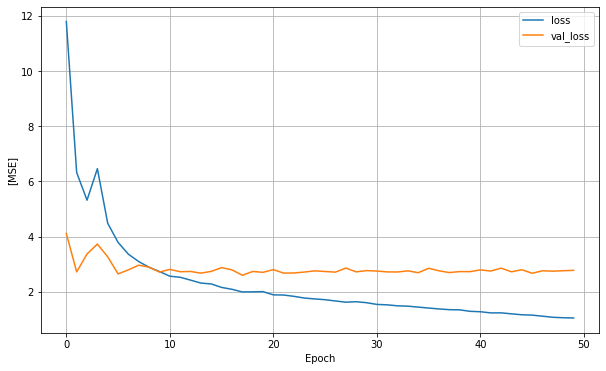

In [ ]:
plot_loss(history_2)

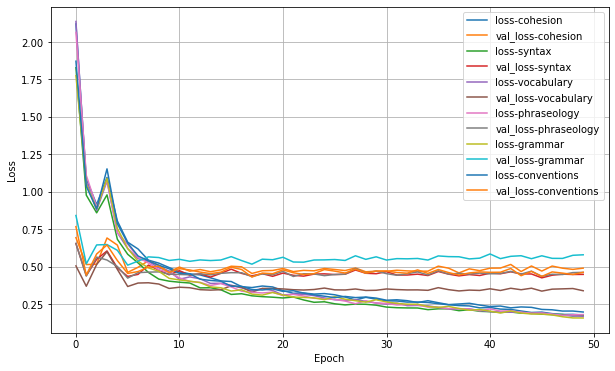

In [ ]:
plot_full_loss(history_2)

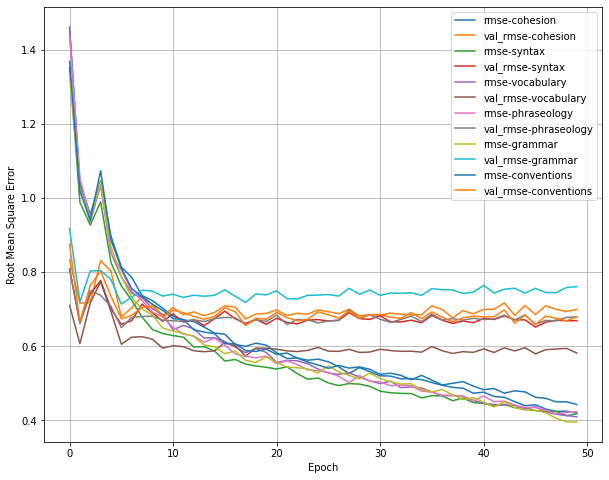

In [ ]:
plot_full_rmse(history_2)

In [ ]:
### It can be seen that Vocabulary is sort of easier to catch, 
### as compared to other metrics.
### Meanwhile, cohension is the most difficult in current mode. 

### It's kinda of expected that since Cohesion refers to the way we use 
### vocabulary and grammatical structures to make connections between the ideas 
### within the whole text.

### current model with the extra layer of Bi-directional LSTM, still has problems
### such as bottleneck problem,etc. Meanwhile, especially as we go deeper in neural architectures,
### the problem of vanishing/exploding gradient is still there.


### Further architectures on transfer learning and more direct connections which
### helps the gradient flowing would be prefered.

In [ ]:
prediction_LSTM = model_custom.predict(X_test)
prediction_LSTM

1/1 [==============================] - 0s 182ms/step


[array([[3.3076944],
        [3.1130195],
        [2.959309 ]], dtype=float32), array([[3.078555 ],
        [2.9177222],
        [2.7589607]], dtype=float32), array([[3.2969449],
        [3.3198504],
        [3.0097318]], dtype=float32), array([[3.1900346],
        [3.0020082],
        [2.8643563]], dtype=float32), array([[2.878889 ],
        [2.5772502],
        [2.5699792]], dtype=float32), array([[3.1666558],
        [3.1046286],
        [2.946725 ]], dtype=float32)]

In [ ]:
for i in range(len(EEL_metrics)):
    column = EEL_metrics[i]
    sample_sub[column] = prediction_LSTM[i][:]   

sample_sub

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.307694,3.078555,3.296945,3.190035,2.878889,3.166656
1,000BAD50D026,3.113019,2.917722,3.319850,3.002008,2.577250,3.104629
2,00367BB2546B,2.959309,2.758961,3.009732,2.864356,2.569979,2.946725


### Close mark

#### Going through different models and trails, it's still quite challenging for nlp in cohesion. There has been studies on Sytax-Bert, focusing on Syntax only. Meanwhile, in overall models, DeBerta performs much better, and that requires a large amount of computing resourses and spaces. Personal colab account and computers are not suitable for this kind of task.

### However, Things are getting better and better.